# CSCI 3022 Final Project Part II


In [1]:
NAME = "Ryan McCarroll"
COLLABORATORS = "None"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%matplotlib inline
import sklearn
import patsy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## Overview

In my current position I help credit unions buy and sell pools of loans from one another. If the reader is unfamiliar, a credit unions is financial institutions that function in a similar fashion as banks. There some important distinctions but they are beyond the scope of this description.  Credit union financial activities are regulated by the National Credit Union Administration which requires that credit union publish its financial results quarterly. These financial results include each line item of the balance sheet and income statement for all credit unions. For this project, I will take the aggregated financial statements and try to answer some interesting questions about the data.

## Description of Problem

As noted above, my current role at my company is to help facilitate the purchase and sale of pools of loans. When one credit union buys/sells a pool of loans from another credit union, the transaction is called a loan participation. In each participation, there is a buyer and a seller. In general, there are several distinct motivations for each the buyer and seller as to why they would want to take part in the transaction. 

In the current marketplace, there exists a significant supply and demand imbalance for these transactions. There are far more willing buyers than willing sellers. Most credit unions have too much cash on their balance sheet that they would rather be invested in more productive and higher yielding assets. However, there is very little demand for credit in the U.S. primarily due to elevated savings rates resulting from federal stimulus money. 

As a result, I am interested in identifying the institutions that have sold loan participations in the past year. In particular, what are the common factors that selling institutions share.  

### Goal and Type of Analysis to be Done

My goal will be to create a predictive model that will indicate whether a credit union will be a likely seller based on their financial statements. I initially thought that this would be a problem well suited for a KNN algorithm. However after working throug the data, I realized that it is best suited for a logistic regression model. The goal of the analysis will be to create a model which predicts the likelihood of a particular institution being an LP seller. If they are predicted to be a seller, but are not then they are good candidates for our sales staff. I will use two traditional measures of liquidity as variables to predict the likelihood of a credit union having sold a participation. 

## Description of Data

Each quarter every credit union regulated by the NCUA is required to submit their financial statements in standardized format. Each line item on the balance sheet and income statement has an associated classification code. For example, the total assets of an institution is saved as A010. The NCUA takes each of the credit union's data collected this way and publishes the results of all credit unions nation wide. The data can be found at the NCUA website. https://www.ncua.gov/analysis/credit-union-corporate-call-report-data/quarterly-data The data is published in a zip file which contain the various 'tables' that contain related information. Additionally, there is a table that shows the account code, its associated description, which table it can be found and some other pertinent items. Below is the head of the account descriptions to give a flavor of the data set. 

In [3]:
AcctDesc = pd.read_csv('AcctDesc.txt', dtype='unicode')
AcctDesc.head()


,Account,AcctName,AcctDesc,TableName,Annualize,CBSAccount,FPRAccount,STATAcctMain,STATAcctState,STATAcctGraph,STATAcctTable8
0,Acct_001,Amount - Total Other Loans (Purchased or to no...,Include the dollar amount of outstanding loans...,FS220A,False,True,True,True,True,False,False
1,Acct_002,Amount of Leases Receivable,"Leases Receivable. Include the rate, number, a...",FS220A,False,False,False,False,False,False,False
2,Acct_003,Loans Held for Sale,Loans Held for Sale. Report the amount of outs...,FS220C,False,False,False,False,False,False,False
3,Acct_007,Land and Building,"Land and building, less depreciation on buildi...",FS220,False,True,True,True,True,False,True
4,Acct_008,Other Fixed Assets,All other fixed assets such as furniture and f...,FS220,False,True,True,True,True,False,True


The size of the data set is quite large - there are over 2,700 distinct data points. However, most of these data points are not relevant for the problem discussed above

In [4]:
len(AcctDesc)

2698

In [5]:
fs220 = pd.read_csv('FS220.txt', dtype='unicode')

Additionally, there are 5207 distinct credit unions. 

In [6]:
len(fs220['CU_NUMBER'])

5207

## Exploritory Data Analysis

The first thing that I need to do is to reduce the size of the feature list. I am only concerned with the factors that are related to loan participations. Most items in the balance sheet and income statement are not relevant to that problem. The data points that I will need are: 

- Total Assets (010)
- Participation Loans Sold Year-To-Date (691N)
- The participation portfolio breakdown - i.e. Consumer, Student Loans, Real Estate, etc (691N1, 691N7, 691N2, 691N2, 691N8, 691N9, 691N6)
- Total Loans (025B)
- Total Shares (018)
- Total Cash (730A, 730B)

These items are the factors that I expect to drive the need to sell - namely liquidity risk and concentration risk. 

First I need to find the tables that these are located in. 

In [7]:
#These are the accounts needed. 
acct = ["Acct_010", "Acct_691N", "Acct_691N1", "Acct_691N7","Acct_691N2","Acct_691N8","Acct_691N9","Acct_691N6","Acct_025B", "Acct_018", "Acct_730A", "Acct_730B"]

AcctDesc.loc[AcctDesc['Account'].isin(acct)]

,Account,AcctName,AcctDesc,TableName,Annualize,CBSAccount,FPRAccount,STATAcctMain,STATAcctState,STATAcctGraph,STATAcctTable8
13,Acct_010,TOTAL ASSETS,TOTAL ASSETS,FS220,False,True,True,True,True,True,True
27,Acct_018,Total Amount of Shares and Deposits,Should include the sum of all deposits both me...,FS220,False,True,True,True,True,True,True
192,Acct_025B,Total amount of Loans and Leases,Total amount of Loans and Leases,FS220,True,True,True,True,True,True,True
1573,Acct_691N,Total Outstanding Amount of Participation Loan...,Total Outstanding Amount of Participation Loan...,FS220G,False,False,False,False,False,False,False
1574,Acct_691N1,Outstanding Amount of Consumer Participation L...,Outstanding Amount of Consumer Participation L...,FS220G,False,False,False,False,False,False,False
1575,Acct_691N2,Outstanding Amount of Real Estate Participatio...,Outstanding Amount of Real Estate Participatio...,FS220G,False,False,False,False,False,False,False
1579,Acct_691N6,Outstanding Amount of Loan Pools Participation...,Outstanding Amount of Loan Pools Participation...,FS220G,False,False,False,False,False,False,False
1580,Acct_691N7,Outstanding Amount of Non-Federally Guaranteed...,Outstanding Amount of Non-Federally Guaranteed...,FS220H,False,False,False,False,False,False,False
1581,Acct_691N8,Outstanding Amount of Commercial Loans Excludi...,Outstanding Amount of Commercial Loans Excludi...,FS220L,False,False,False,False,False,False,False
1582,Acct_691N9,Outstanding Amount of Commercial Construction ...,Outstanding Amount of Commercial Construction ...,FS220L,False,False,False,False,False,False,False


Next I need to pull the data out of the needed tables and join them into a my data frame. FS220 is already loaded, need to load the next two. 

In [8]:
fs220G = pd.read_csv('FS220G.txt', dtype='unicode')
fs220H = pd.read_csv('FS220H.txt', dtype='unicode')
fs220L = pd.read_csv('FS220L.txt', dtype='unicode')
fs220A = pd.read_csv('FS220A.txt', dtype='unicode')

In [9]:
#Select needed columns from relavant tables
tmpfs220 = fs220[["ACCT_010", "ACCT_018", "ACCT_025B"]]
tmpfs220G  = fs220G[["ACCT_691N", "ACCT_691N1","ACCT_691N2","ACCT_691N6"]]
tmpfs220H  = fs220H[["Acct_691N7"]]
tmpfs220L = fs220L[["ACCT_691N8", "ACCT_691N9"]]
tmpfs220A = fs220A[["Acct_730A", "Acct_730B"]]
#join to single datafram
df = pd.concat([tmpfs220.reset_index(drop=True), tmpfs220G, tmpfs220H, tmpfs220L, tmpfs220A ], axis=1)



Now I need to change the data type to numeric.  

In [10]:
df['ACCT_010'] = pd.to_numeric(df['ACCT_010'])
df['ACCT_018'] = pd.to_numeric(df['ACCT_018'])
df['ACCT_691N'] = pd.to_numeric(df['ACCT_691N'])
df['ACCT_691N1'] = pd.to_numeric(df['ACCT_691N1'])
df['ACCT_691N2'] = pd.to_numeric(df['ACCT_691N2'])
df['ACCT_691N6'] = pd.to_numeric(df['ACCT_691N6'])
df['ACCT_025B'] = pd.to_numeric(df['ACCT_025B'])
df['ACCT_691N8'] = pd.to_numeric(df['ACCT_691N8'])
df['ACCT_691N9'] = pd.to_numeric(df['ACCT_691N9'])
df['ACCT_691N9'] = pd.to_numeric(df['ACCT_691N9'])
df['Acct_730B'] = pd.to_numeric(df['Acct_730B'])

Well that was a slog to get that together, but now I think I have all of the relevant data points in a single data frame. Lets start by looking at the distribution of asset size. 

First lets start by looking at the relative size of credit unions. As you can see by the histograms. Most credit unions are small and there are a few HUGE ones that skew the distribution. 

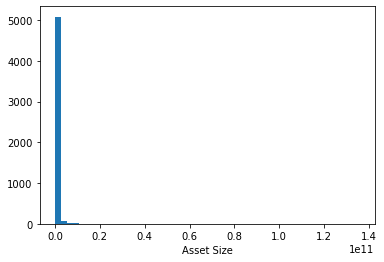

In [11]:
plt.hist(df["ACCT_010"], bins=50, label="Data")
plt.xlabel("Asset Size")
plt.show()


So I need to scale the relevant data points by asset size. The easiest way to do that is to is to 'common size' the data points. That is to divide them by assets. Additionally, I will use another common liquidity measurement of loans to shares. 

In [12]:
df["Cash_to_Assets"] = df['Acct_730B'] / df['ACCT_010']
df['Loans_to_Shares'] = df['ACCT_025B'] / df['ACCT_018']

Lets look at a distribution of the transformed data points. 

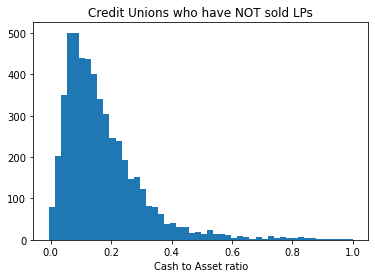

In [13]:
plt.hist(df["Cash_to_Assets"], bins=50, label="Data")
plt.title("Credit Unions who have NOT sold LPs")
plt.xlabel("Cash to Asset ratio")
plt.show()

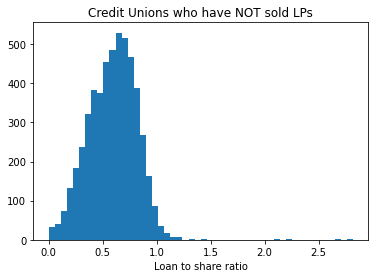

In [14]:
plt.hist(df["Loans_to_Shares"], bins=50, label="Data")
plt.title("Credit Unions who have NOT sold LPs")
plt.xlabel("Loan to share ratio")
plt.show()

In general these are opposite ways to measure liquidity, which is why the distributions tend to be mirror images. The next question is how this relates to the propensity to sell a loan participation. 

In [15]:
#create a distribution with only CUs that have sold loan participations.Will use this to compare distributions. 
dfLP = df.loc[df['ACCT_691N']>0]

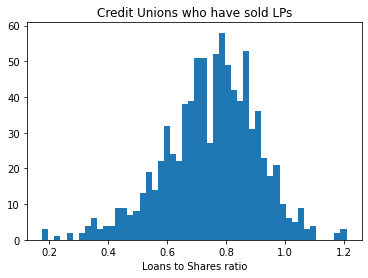

In [16]:
plt.hist(dfLP["Loans_to_Shares"], bins=50, label="Data")
plt.title("Credit Unions who have sold LPs")
plt.xlabel("Loans to Shares ratio")
plt.show()

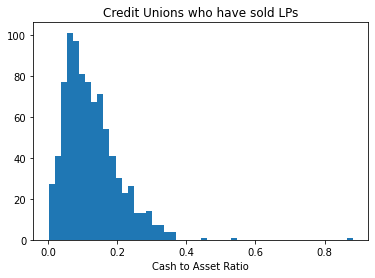

In [17]:
plt.hist(dfLP["Cash_to_Assets"], bins=50, label="Data")
plt.title("Credit Unions who have sold LPs")
plt.xlabel("Cash to Asset Ratio")
plt.show()

It does appear that the credit unions that have sold participation have higher loan to share ratios and lower cash to asset ratios. Finally, I will look at the mean of those two databases. 

In [18]:
CAall = df.Cash_to_Assets.mean()
CAlp = dfLP.Cash_to_Assets.mean()
LSall = df.Loans_to_Shares.mean()
LSlp = dfLP.Loans_to_Shares.mean()

print('Loan to share ratio for CUs that have sold is ', LSlp, 'Vs. all CUs', LSall, "Cash to assets for CUs that have sold",
     CAlp, 'Vs. all CUs', CAall)

Loan to share ratio for CUs that have sold is  0.7475913626103923 Vs. all CUs 0.5916798264402676 Cash to assets for CUs that have sold 0.1251192665145429 Vs. all CUs 0.16940459128566854


Based on my experience, that seems to be a significant difference, but that's what the model will hopefully predict. 

## Remove outlier data

I noticed in the data that there were a few outlier data points. I can say based on my industry experience that a loan to share ratio over 1.50 is nonsensical. That has to be a data input error. Therefore, I am going to remove those. 

In [19]:
df = df.loc[df['Loans_to_Shares']<1.50]

## Relationship between predictor variables. 

My assumption is that either a combination of loan to share ratio or a cash to assets ratio would predict a credit unions propensity to sell a loan participation. However, these are both measures of liquidity albeit in different ways. Loans to shares measures the proportion of deposits that the institution has lent out. A ratio of 100% means that the all deposits have been lent out and they must rely on capital or borrowings to lend. Cash to assets measures the amount of cash held on the balance sheet. This is a more simple measure, but a credit union could have a low cash to assets ratio but not a high loan to share (lots of investments instead of loans). In general, one would expect a negative relationship between the two variables. In other words institutions with high loan to share ratios should be tight on cash. If these are too correlated, it might be worth finding a third variable. However, that does not appear to be the case for either the subset of CUs that have sold or the subset that has not sold a participation. 

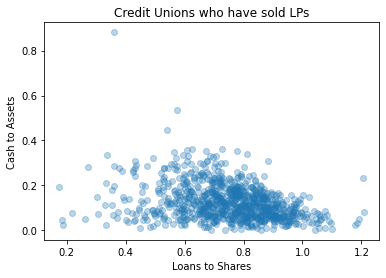

In [20]:
plt.plot(dfLP["Loans_to_Shares"], dfLP["Cash_to_Assets"], 'o', alpha=0.3)
plt.title("Credit Unions who have sold LPs")
plt.xlabel("Loans to Shares")
plt.ylabel("Cash to Assets")
plt.show()

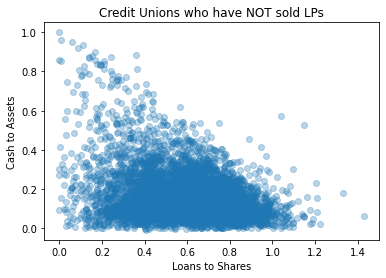

In [21]:
plt.plot(df["Loans_to_Shares"], df["Cash_to_Assets"], 'o',alpha=0.3)
plt.title("Credit Unions who have NOT sold LPs")
plt.xlabel("Loans to Shares")
plt.ylabel("Cash to Assets")
plt.show()

Up to this point, I have two separate data frames for seller / non-seller. Need to create the column in the original dataframe. This will also allow me to use the 0/1 classification for the dependent variable.  

In [22]:
df["LPSeller"] = df.ACCT_691N >0
df['LPSeller'] = (df['LPSeller'] == True ).astype(int) #turn to 0/1 vs. False/True
df.LPSeller
print("Of all ", len(df["ACCT_691N"]), " Credit unions", df.LPSeller.sum(), "have sold participations")


Of all  5203  Credit unions 878 have sold participations


## Model

I have gone back and forth on the best model to use. I have landed on my "proper single model" per the rubric to be a logistic regression. That seems to me to be the most appropriate in this context. I want to know what the likelihood of a credit union being a seller based on their loan to share ratio and their cash to assets ratio. My plan will be to split the data into a training data set and a testing data set. Once the model is trained I will test the efficacy of the model on the testing set. 

I need to start by splitting a training and testing set. 

In [23]:
df_train = df[::2]
df_test = df[1::2] 

Now to train the model...I'm going to start by just looking at loan to share as the relavant measure and then iteratively add additional factors. 

In [24]:
y,X = patsy.dmatrices("LPSeller ~ 0+ Loans_to_Shares", data=df_train)

lr = sklearn.linear_model.LogisticRegression()
mod = lr.fit(X, y.ravel())

yhat = mod.predict(X)

print('Score is', mod.score(X,y.ravel()))

Score is 0.828977709454266


That seems to be a pretty good accuracy score. Not to extend that to the test data. 

In [25]:
y_test, X_test = patsy.dmatrices("LPSeller ~ 0+ Loans_to_Shares", data=df_test)

print('Score is', mod.score(X_test, y_test.ravel()))

Score is 0.8266051518646674


The accuracy is a little bit worse but still pretty good. Not lets look at some visuals to assess the model. 

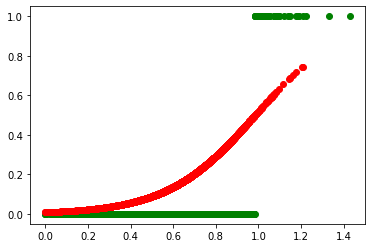

In [26]:
yhat_test = mod.predict(X_test)


def logistic(model, x):
    z = np.exp(model.intercept_ + model.coef_ * x)
    return  z / (1 + z)

plt.plot(X_test,yhat_test,'go');

plt.plot(X, logistic(mod, X), 'ro')
#plt.show()


Finally, I want to try a multifactor model including the Cash to Assets ratio to see if that brings additional accuracy to the model. 

In [27]:
y,X = patsy.dmatrices("LPSeller ~ 0+ Loans_to_Shares + Cash_to_Assets", data=df_train)

lr = sklearn.linear_model.LogisticRegression()
mod = lr.fit(X, y.ravel())

yhat = mod.predict(X)

#print(sklearn.metrics.confusion_matrix(X, yhat))
print('Score is', mod.score(X,y.ravel()))

Score is 0.8324365872405841


This actually works slightly better, but does not seem to make a huge difference. Let's try it on the testing dataset. 

In [28]:
y_test, X_test = patsy.dmatrices("LPSeller ~ 0+ Loans_to_Shares+Cash_to_Assets", data=df_test)

print('Score is', mod.score(X_test, y_test.ravel()))

Score is 0.8262206843521722


This is almost identical to the results of runing the model on the test set using only loan to share. As a result I will stick to the more parsimoneous model in my analysis. 

## Conclusion and implications

This was an interesting analysis and could potentially be helpful in identifying credit unions that are not presently selling loan participations, but may be good candidates to sell in the near future. I can use the predict function on the above model to spit out the credit unions that I would like our sales staff to target in the coming months. 

As noted earlier, there appeared to be some collinearity between the two variables causing there to not be much change in the multifactor model. I suspect there would be at least a few other variables in the serveral thousand variables that would be helpful in increasing the accuracy. That would be one area to improve the model. 